<a href="https://colab.research.google.com/github/maltevolle/PMML-Project/blob/michael/Workcopy_Project_PMML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import files
files.upload() #upload kaggle.json

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"gmichael18","key":"5fe75497a7bfe169343c2ff518a2adb4"}'}

In [6]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [7]:
! kaggle datasets download -d alessiocorrado99/animals10

Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10
License(s): GPL-2.0
 99% 579M/586M [00:05<00:00, 60.6MB/s]
100% 586M/586M [00:05<00:00, 108MB/s] 


In [8]:
! unzip animals10.zip && rm animals10.zip

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  inflating: raw-img/ragno/OIP-MVQChNQpHiMZEVMPehrvoAHaE6.jpeg  
  inflating: raw-img/ragno/OIP-MVdIFDAFpNyK_XCpwkDIWgHaFj.jpeg  
  inflating: raw-img/ragno/OIP-MYY_8k5AHqMJwTCNXfH6rwHaFj.jpeg  
  inflating: raw-img/ragno/OIP-MZEVXuoMsATG8u_UuTQ6hAHaE8.jpeg  
  inflating: raw-img/ragno/OIP-MZg0tznDRE95AMfyuutuYAHaE6.jpeg  
  inflating: raw-img/ragno/OIP-M_r9DkR2X5gP0P5-z8wPYQHaE7.jpeg  
  inflating: raw-img/ragno/OIP-M_xDUSzjlF3-w9XHCm93cgHaFF.jpeg  
  inflating: raw-img/ragno/OIP-MbI4-bMyutRX3X382IAVcQAAAA.jpeg  
  inflating: raw-img/ragno/OIP-MbMksZdD7gomsC9fd6cpKgHaHJ.jpeg  
  inflating: raw-img/ragno/OIP-Md4AMcvjaHcivJqeW06wEwHaFW.jpeg  
  inflating: raw-img/ragno/OIP-MgCgailkT5XkO1XczzQCngHaLK.jpeg  
  inflating: raw-img/ragno/OIP-MgrKq05YHGXsgj1AmYIyJQHaE8.jpeg  
  inflating: raw-img/ragno/OIP-MhRGx7d8nbnHBuqrsO00EQHaFo.jpeg  
  inflating: raw-img/ragno/OIP-MiVgMXcKGQdog2KGe7i0YQHaHh.jpeg  
  inflating: raw-img/ra

In [9]:
import numpy as np
from torch import nn
import torch
from torch import optim
import torchvision
from torchvision import models
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
from torchvision import transforms, utils
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split



# Image Processing


In [10]:
train_transforms = transforms.Compose([transforms.Resize(140),
                                       transforms.CenterCrop(140),
                                       transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5,),(0.5,))])
test_transforms = transforms.Compose([transforms.Resize(140),
                                      transforms.CenterCrop(140),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,),(0.5))])

In [11]:
# Load dataset
dataset = ImageFolder('../content/raw-img')
# Load dataset for visualisation
raw_dataset = ImageFolder('../content/raw-img',
    transform=transforms.Compose([
        transforms.Resize((140, 140)),  # Resize all images to 140x140
        transforms.ToTensor()          # Convert images to tensors
    ])
)

# Extract indices and labels for splitting
indices = np.arange(len(dataset))
labels = [label for _, label in dataset]

# Split dataset into training and testing indices
train_indices, test_indices = train_test_split(
    indices, test_size=0.2, stratify=labels, random_state=42
)

# Create subsets for training and testing
train_set = Subset(dataset, train_indices)
test_set = Subset(dataset, test_indices)

# Apply test/train transforms to the test/train set
test_set.dataset.transform = test_transforms
train_set.dataset.transform = train_transforms


# Create data loaders
batch_size = 20
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
raw_loader = DataLoader(raw_dataset, batch_size=batch_size, shuffle=True)

# Visualisation

In [12]:
# Function for visualizing images
def visualize_images(dataset_loader, classes, title="Images"):
    """
    Visualize a batch of images from a DataLoader.

    Args:
    - dataset_loader (DataLoader): The DataLoader containing the images to visualize.
    - classes (list): List of class names for labels.
    - title (str): Title of the visualization plot.
    """
    images, labels = next(iter(dataset_loader))
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(20):
        ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
        imshow(images[idx])
        ax.set_title(classes[labels[idx]])
    plt.suptitle(title)
    plt.show()


def imshow(img):
    """
    Helper function to unnormalize and display an image.
    """
    img = img / 2 + 0.5  # Unnormalize
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))

Visualizing Before Applying Transforms:


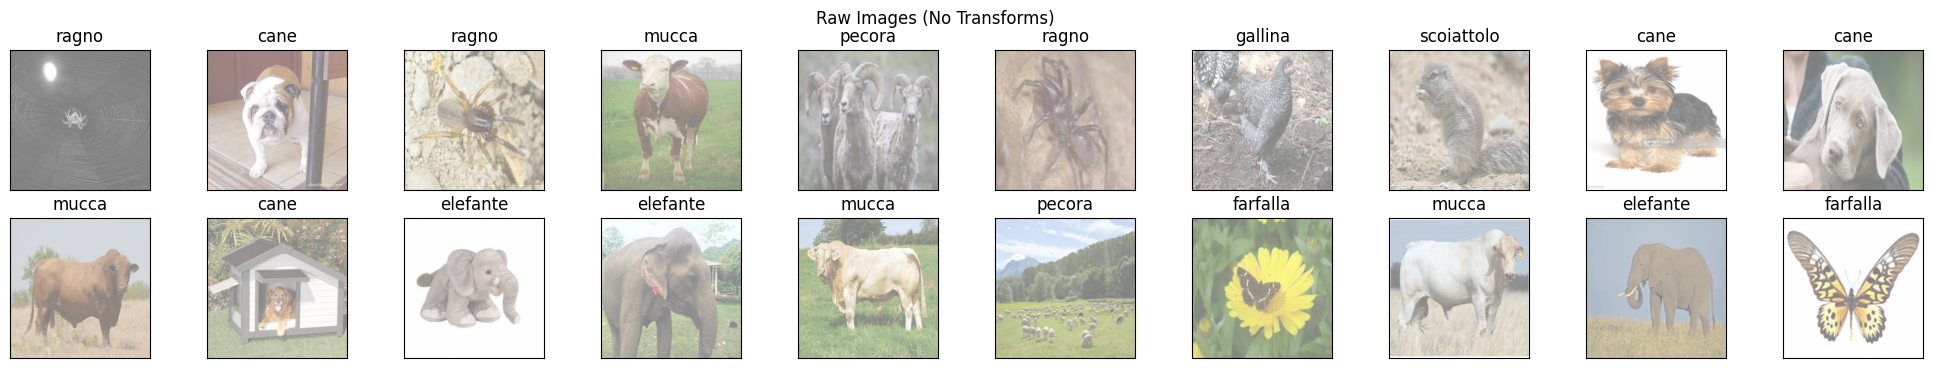

Visualizing After Applying Transforms:


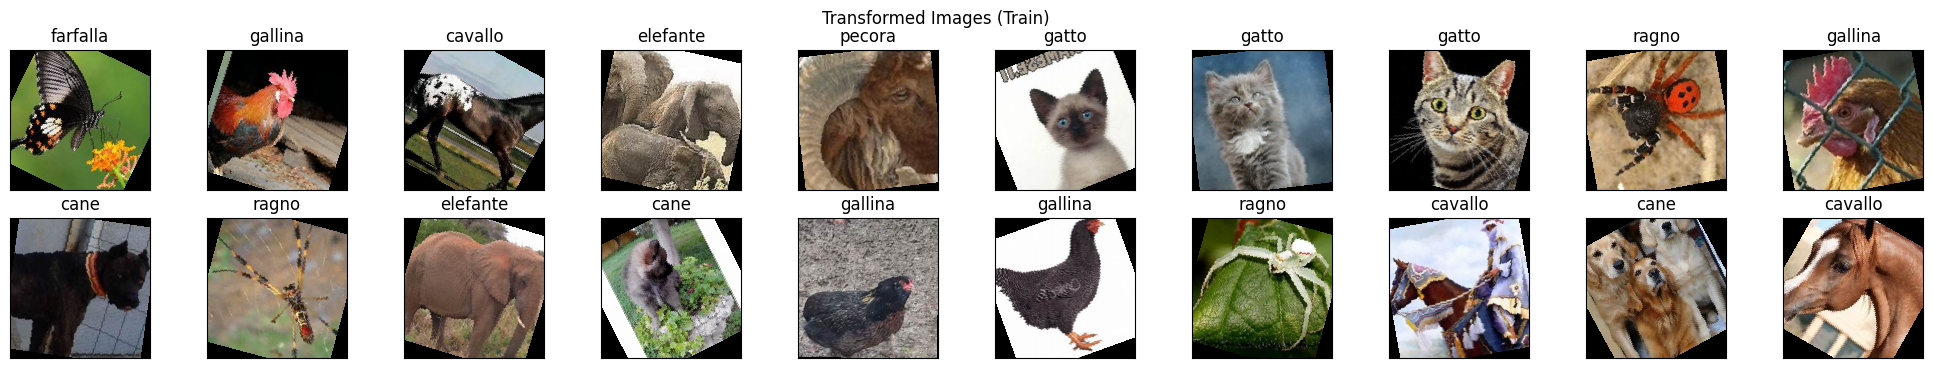

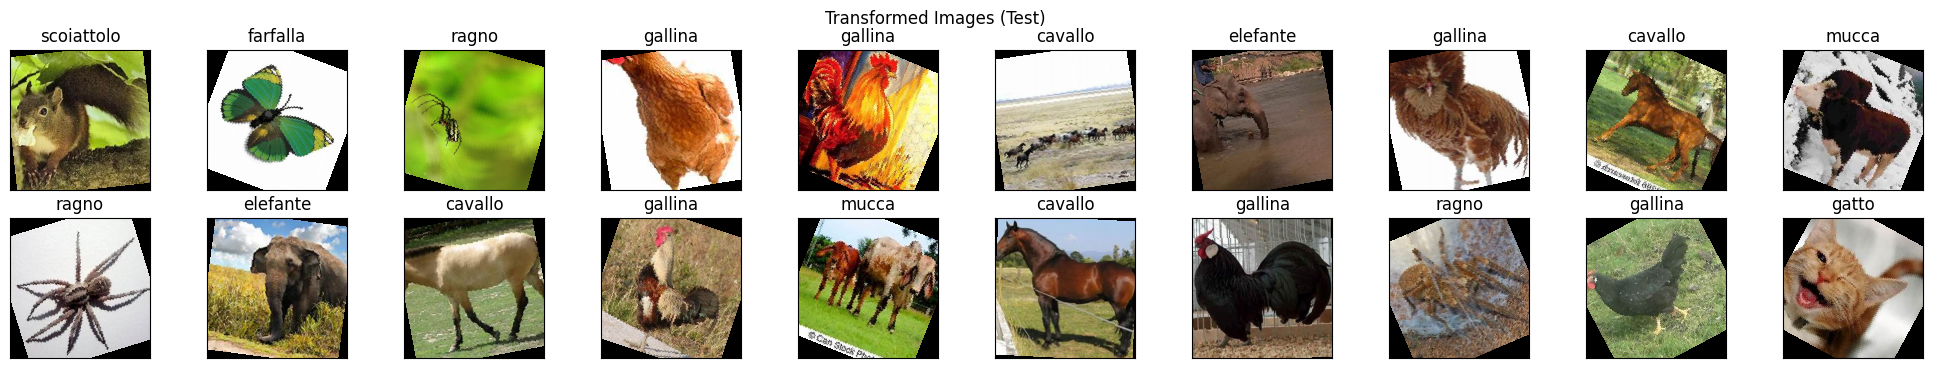

In [13]:
# Visualize before applying transforms
print("Visualizing Before Applying Transforms:")
visualize_images(raw_loader, raw_dataset.classes, title="Raw Images (No Transforms)")

# Visualize after applying transforms
print("Visualizing After Applying Transforms:")
visualize_images(train_loader, dataset.classes, title="Transformed Images (Train)")
visualize_images(test_loader, dataset.classes, title="Transformed Images (Test)")

# Basic Stats

In [14]:
classes = dataset.classes
translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel", "dog": "cane", "cavallo": "horse", "elephant" : "elefante", "butterfly": "farfalla", "chicken": "gallina", "cat": "gatto", "cow": "mucca", "spider": "ragno", "squirrel": "scoiattolo"}
t_inv = {v: k for k, v in translate.items()}
classes


['cane',
 'cavallo',
 'elefante',
 'farfalla',
 'gallina',
 'gatto',
 'mucca',
 'pecora',
 'ragno',
 'scoiattolo']

# Building the Classifier

In [15]:
res_18_model = models.resnet18(pretrained=True)
res_18_model.fc= nn.Linear(512, 10)

model=res_18_model
if(torch.cuda.is_available()==True):
    model=res_18_model.cuda()

optimiser=optim.SGD(model.parameters(),lr=1e-2)
loss=nn.CrossEntropyLoss()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Training Loop

In [16]:
!pip install wandb -qU

# Log in to your W&B account
import wandb
import random
import math


In [17]:
wandb.login()

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="PMML",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.02,
    "architecture": "ResNet",
    "dataset": "Animal10",
    "epochs": 4,
    }
)

wandb: Currently logged in as: michael-girsh (michael-girsh-ruhr-university-bochum). Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [18]:
from tqdm import tqdm  # For progress bar

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=2, gamma=0.1)  # Reduce LR every 2 epochs

nb_epochs = 4
for epoch in range(nb_epochs):
    # Training Phase
    model.train()
    train_losses = []
    train_accuracies = []

    print(f"Epoch {epoch + 1}/{nb_epochs}")
    for x, y in tqdm(train_loader, desc="Training", leave=False):
        if torch.cuda.is_available():
            x, y = x.cuda(), y.cuda()

        # Forward pass
        outputs = model(x)

        # Compute the loss
        J = loss(outputs, y)

        # Zero the gradients
        optimiser.zero_grad()

        # Backward pass
        J.backward()

        # Optimizer step
        optimiser.step()

        # Record loss
        train_losses.append(J.item())

        # Compute accuracy
        _, predictions = torch.max(outputs, dim=1)
        acc = (predictions == y).float().mean()  # Mean accuracy for the batch
        train_accuracies.append(acc.item())

        # Log batch-wise metrics to W&B
        wandb.log({
            "Train Batch Loss": J.item(),
            "Train Batch Accuracy": acc.item(),
            "Epoch": epoch + 1,
            "Learning Rate": scheduler.get_last_lr()[0],
        })

    # Compute epoch training metrics
    avg_train_loss = np.mean(train_losses)
    avg_train_accuracy = np.mean(train_accuracies)

    # Validation Phase
    model.eval()
    val_losses = []
    val_accuracies = []
    with torch.no_grad():
        for x, y in tqdm(test_loader, desc="Validating", leave=False):
            if torch.cuda.is_available():
                x, y = x.cuda(), y.cuda()

            # Forward pass
            outputs = model(x)

            # Compute the loss
            J = loss(outputs, y)
            val_losses.append(J.item())

            # Compute accuracy
            _, predictions = torch.max(outputs, dim=1)
            acc = (predictions == y).float().mean()
            val_accuracies.append(acc.item())

    # Compute epoch validation metrics
    avg_val_loss = np.mean(val_losses)
    avg_val_accuracy = np.mean(val_accuracies)

    # Step the learning rate scheduler
    scheduler.step()

    # Log metrics to W&B
    wandb.log({
        "Epoch": epoch + 1,
        "Train Loss": avg_train_loss,
        "Train Accuracy": avg_train_accuracy,
        "Val Loss": avg_val_loss,
        "Val Accuracy": avg_val_accuracy,
        "Learning Rate": scheduler.get_last_lr()[0],  # Log current learning rate
    })

    # Print epoch summary
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.4f}")
    print(f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_accuracy:.4f}")


Epoch 1/4


KeyboardInterrupt: 

# Adversial Attacks

In [19]:
!pip install torchattacks

In [20]:
import torchattacks  # For adversarial attacks

ModuleNotFoundError: No module named 'utils'

### Targeted Misclassification

#### Own Target Model

In [ ]:
class AdversarialGenerator(nn.Module):
    """
    A trainable adversarial generator to create adversarial examples.
    """
    def __init__(self, input_size):
        super(AdversarialGenerator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, input_size),
            nn.Tanh(),  # Ensures perturbations are bounded
        )

    def forward(self, x):
        perturbation = self.fc(x.view(x.size(0), -1))
        return perturbation.view(x.size())  # Reshape to input size


# Initialize the generator
input_size = 3 * 140 * 140  # Assuming 3 channels and 140x140 images
generator = AdversarialGenerator(input_size)
if torch.cuda.is_available():
    generator = generator.cuda()

# Loss function and optimizer
adv_optimizer = optim.Adam(generator.parameters(), lr=1e-4)
target_class = 3  # Specify target class to misclassify

# Training Loop
for epoch in range(10):  # Train for 10 epochs
    generator.train()
    for x, y in train_loader:
        if torch.cuda.is_available():
            x, y = x.cuda(), y.cuda()

        # Generate perturbations
        perturbations = generator(x)
        adv_examples = torch.clamp(x + perturbations, 0, 1)  # Add perturbations and clip

        # Compute loss using the victim model
        outputs = best_model(adv_examples)
        target_labels = torch.full_like(y, target_class).to(y.device)
        adv_loss = nn.CrossEntropyLoss()(outputs, target_labels)

        # Backpropagation
        adv_optimizer.zero_grad()
        adv_loss.backward()
        adv_optimizer.step()

    print(f"Epoch {epoch + 1}, Adversarial Loss: {adv_loss.item():.4f}")

# Evaluate the Adversarial Generator
generator.eval()
adv_correct, total = 0, 0
for x, y in test_loader:
    if torch.cuda.is_available():
        x, y = x.cuda(), y.cuda()

    perturbations = generator(x)
    adv_examples = torch.clamp(x + perturbations, 0, 1)
    outputs = best_model(adv_examples)
    _, preds = torch.max(outputs, 1)

    total += y.size(0)
    adv_correct += (preds == target_class).sum().item()

adv_accuracy = adv_correct / total
print(f"Adversarial Generator Success Rate (misclassified as {target_class}): {adv_accuracy:.4f}")


#### FGSM

In [21]:
from torchattacks import FGSM

In [28]:
t_atk_fgsm = FGSM(model, eps=8/255)
t_atk_fgsm.set_normalization_used(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
num_classes = 10
t_atk_fgsm.set_mode_targeted_by_function(target_map_function=lambda images, labels:(labels+1)%num_classes)
print(t_atk_fgsm)

Attack mode is changed to 'targeted(custom)'.
FGSM(model_name=ResNet, device=cpu, attack_mode=targeted(custom), targeted=True, normalization_used=True, eps=0.03137254901960784)


In [ ]:
target_correct, total = 0, 0
for images, labels in test_loader:
    if torch.cuda.is_available():
        images, labels = images.cuda(), labels.cuda()

    # Generate adversarial examples
    adv_images = t_atk_fgsm(images, labels)

    # Evaluate the model on adversarial examples
    outputs = model(adv_images)
    _, preds = torch.max(outputs, dim=1)
    probs = torch.nn.functional.softmax(outputs, dim=1)  # Get probabilities

    # Log real and adversarial predictions
    for i in range(images.size(0)):
        real_label_idx = labels[i].item()
        adv_label_idx = preds[i].item()

        real_label = dataset.classes[real_label_idx]
        adv_label = dataset.classes[adv_label_idx]

        # Calculate the accuracy (confidence score)
        real_accuracy = probs[i][real_label_idx].item()
        adv_accuracy = probs[i][adv_label_idx].item()

        # Print the labels and accuracies
        print(f"Original prediction: ('{real_label}', {real_label_idx}) - Accuracy: {real_accuracy:.4f}")
        print(f"Adversarial prediction: ('{adv_label}', {adv_label_idx}) - Accuracy: {adv_accuracy:.4f}")

    # Count successful targeted attacks
    total += labels.size(0)
    target_correct += (preds == (labels + 1) % 10).sum().item()

print(f"FGSM Targeted Attack Success Rate: {target_correct / total:.4f}")

Original prediction: ('scoiattolo', 9) - Accuracy: 0.0381
Adversarial prediction: ('farfalla', 3) - Accuracy: 0.4161
Original prediction: ('farfalla', 3) - Accuracy: 0.9856
Adversarial prediction: ('farfalla', 3) - Accuracy: 0.9856
Original prediction: ('ragno', 8) - Accuracy: 0.6573
Adversarial prediction: ('ragno', 8) - Accuracy: 0.6573
Original prediction: ('gallina', 4) - Accuracy: 0.8451
Adversarial prediction: ('gallina', 4) - Accuracy: 0.8451
Original prediction: ('gallina', 4) - Accuracy: 0.5018
Adversarial prediction: ('gallina', 4) - Accuracy: 0.5018
Original prediction: ('cavallo', 1) - Accuracy: 0.0257
Adversarial prediction: ('pecora', 7) - Accuracy: 0.4430
Original prediction: ('elefante', 2) - Accuracy: 0.0187
Adversarial prediction: ('ragno', 8) - Accuracy: 0.6767
Original prediction: ('gallina', 4) - Accuracy: 0.0676
Adversarial prediction: ('cavallo', 1) - Accuracy: 0.2068
Original prediction: ('cavallo', 1) - Accuracy: 0.0589
Adversarial prediction: ('farfalla', 3) -

### Untargeted Misclassification

#### FGSM

In [ ]:
from torchattacks import FGSM

In [ ]:
u_atk_fgsm = FGSM(model, eps=8/255)
u_atk_fgsm.set_normalization_used(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
print(u_atk_fgsm)

In [ ]:
# Untargeted attack evaluation
untargeted_correct, total = 0, 0
for images, labels in test_loader:
    if torch.cuda.is_available():
        images, labels = images.cuda(), labels.cuda()

    # Generate adversarial examples
    adv_images = u_atk_fgsm(images, labels)

    # Evaluate the model on adversarial examples
    outputs = model(adv_images)
    _, preds = torch.max(outputs, dim=1)

    # Log real and adversarial predictions
    for i in range(images.size(0)):
        real_label_idx = labels[i].item()
        adv_label_idx = preds[i].item()

        real_label = dataset.classes[real_label_idx]
        adv_label = dataset.classes[adv_label_idx]

        # Calculate the accuracy (confidence score)
        real_accuracy = probs[i][real_label_idx].item()
        adv_accuracy = probs[i][adv_label_idx].item()

        # Print the labels and accuracies
        print(f"Original prediction: ('{real_label}', {real_label_idx}) - Accuracy: {real_accuracy:.4f}")
        print(f"Adversarial prediction: ('{adv_label}', {adv_label_idx}) - Accuracy: {adv_accuracy:.4f}")

    # Count successful untargeted misclassifications
    total += labels.size(0)
    untargeted_correct += (preds != labels).sum().item()

print(f"FGSM Untargeted Attack Success Rate: {untargeted_correct / total:.4f}")
